In [1]:
import jax
import jax.numpy as jnp
from evosax import ParameterReshaper
import ipyplot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

# Setup

### Create environment

In [2]:
import gymnax as gym

In [3]:
env_name = "MountainCar-v0"
env, env_params = gym.make(env_name)
n_actions = env.action_space(env_params).n
obs_dims = env.observation_space(env_params).shape[0]

In [4]:
env_steps = env_params.max_steps_in_episode

### Create NDP

In [5]:
from models import HyperNCA, HyperNCA_Config

In [6]:
# MLP configuration
mlp_hidden_dims = max((obs_dims, n_actions)) # nb of features for each hidden layer
mlp_hidden_layers = 1 # nb of hidden layers
mlp_action_dims = n_actions 
mlp_obs_dims = obs_dims

In [7]:
# NCA Configuration
channels = 8
alpha = 0.1 # alive threshold
perception_dims = 3 # nb of perception kernels
update_features = (16,) # hidden features of update network

iterations = 20 #number of development steps

In [8]:
ndp_config = HyperNCA_Config(
    channels = channels,
    alpha = alpha,
    perception_dims = perception_dims,
    update_features = update_features,
    iterations = iterations,
    action_dims = n_actions,
    obs_dims = obs_dims,
    hidden_dims = mlp_hidden_dims,
    hidden_layers = mlp_hidden_layers
)

In [9]:
ndp = HyperNCA(ndp_config)

In [10]:
z_dims = ndp.z_dims # nb of dimensions of the latent space (channels)
z_dims

2

In [11]:
ndp_params = ndp.init(jax.random.PRNGKey(42), jnp.ones((z_dims, )))
parameter_reshaper = ParameterReshaper(ndp_params)

ParameterReshaper: 290 parameters detected for optimization.


### Create evaluator

In [12]:
from evaluators import CompositionalityEvaluator, CompositionalityEvaluator_Config
from envs import bd_mountain_car

In [13]:
evaluator_config = CompositionalityEvaluator_Config(
    epochs = 1,
    env = env,
    env_params = env_params,
    env_steps = 200,
    mlp_hidden_dims = mlp_hidden_dims,
    mlp_hidden_layers = mlp_hidden_layers,
    n_params = z_dims,
    bd_extractor = bd_mountain_car,
    popsize = 100
)

In [14]:
evaluator = CompositionalityEvaluator(evaluator_config, ndp)

### Create Trainer

In [15]:
from metandp import NDP_Trainer, Config

In [16]:
trainer_config = Config(
    epochs = 150,
    n_params = parameter_reshaper.total_params,
    params_shaper = parameter_reshaper,
    es = "des",
    popsize = 64,
    es_config = {},
    es_params = None
)

In [17]:
ndp_trainer = NDP_Trainer(trainer_config, ndp, evaluator)

# Train

In [18]:
key = jax.random.PRNGKey(42)
es_state, data = ndp_trainer.train(key)

	INNER LOOP #0
OUTER LOOP #0 : avg = 0.026554539799690247, top = 0.13613088428974152, best = -0.13613088428974152
	INNER LOOP #0
OUTER LOOP #1 : avg = 0.033248595893383026, top = 0.2440417855978012, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #2 : avg = 0.015899380668997765, top = 0.15207141637802124, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #3 : avg = 0.03624413534998894, top = 0.1625789850950241, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #4 : avg = 0.039558045566082, top = 0.18734951317310333, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #5 : avg = 0.032322268933057785, top = 0.1811533421278, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #6 : avg = 0.031137138605117798, top = 0.16293132305145264, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #7 : avg = 0.0220419242978096, top = 0.1719493865966797, best = -0.2440417855978012
	INNER LOOP #0
OUTER LOOP #8 : avg = 0.017806529998779297, top = 0.19144833087921143, best = -0.244041785597

	INNER LOOP #0
OUTER LOOP #74 : avg = 0.27010852098464966, top = 0.5020233392715454, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #75 : avg = 0.29394686222076416, top = 0.5784714221954346, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #76 : avg = 0.25544023513793945, top = 0.49803462624549866, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #77 : avg = 0.2923451364040375, top = 0.5115079283714294, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #78 : avg = 0.2736530005931854, top = 0.5034956336021423, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #79 : avg = 0.2802373766899109, top = 0.5043385624885559, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #80 : avg = 0.2735559046268463, top = 0.5039264559745789, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #81 : avg = 0.3065933287143707, top = 0.5620096325874329, best = -0.6063801050186157
	INNER LOOP #0
OUTER LOOP #82 : avg = 0.2612669765949249, top = 0.5352246165275574, best = -0.60638010501861

	INNER LOOP #0
OUTER LOOP #148 : avg = 0.31213778257369995, top = 0.49312928318977356, best = -0.670744001865387
	INNER LOOP #0
OUTER LOOP #149 : avg = 0.30307504534721375, top = 0.5414084196090698, best = -0.670744001865387


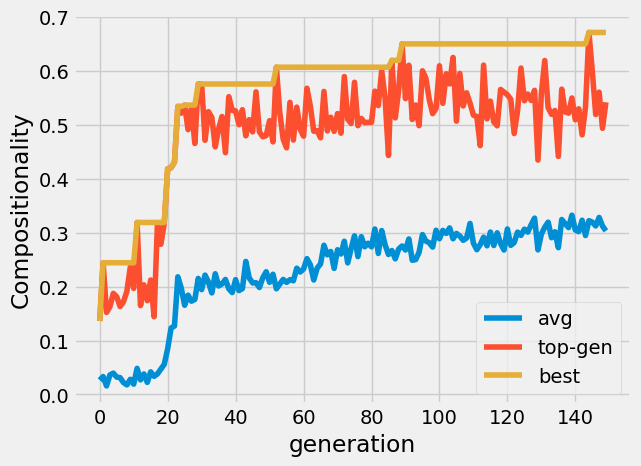

In [19]:
fitness = data['fitness']
avg_fitness = jnp.mean(fitness, axis=-1)
max_fitness = jnp.max(fitness, axis=-1)
best_fitness = -data['es_state'].best_fitness

plt.plot(avg_fitness, label='avg')
plt.plot(max_fitness, label='top-gen')
plt.plot(best_fitness, label='best')
plt.legend()
plt.xlabel('generation')
plt.ylabel('Compositionality')
plt.show()

In [39]:
best_params = es_state.best_member
best_params = parameter_reshaper.reshape(best_params[None, :])
best_params = jax.tree_map(lambda x: x[0], best_params)
test_key = jax.random.PRNGKey(66)
score, test_data = evaluator.test(test_key, best_params, n_samples=1000)
score

Array(0.34785905, dtype=float32)

In [41]:
bd = test_data['bd']
z = test_data['z']
bd.shape, z.shape

((1000, 2), (1000, 2))

In [45]:
df = pd.DataFrame()
for dim in range(z_dims):
    df[f'z_{dim}'] = z[:, dim]
df['bd_0'] = bd[:, 0]
df['bd_1'] = bd[:, 1]

In [82]:
from sklearn.cross_decomposition import PLSSVD, PLSCanonical, PLSRegression, CCA

In [83]:
mod = PLSRegression(n_components=1)
mod.fit(bd, z)
zr = mod.transform(z)
df["zr"] = zr

<Axes: xlabel='bd_0', ylabel='bd_1'>

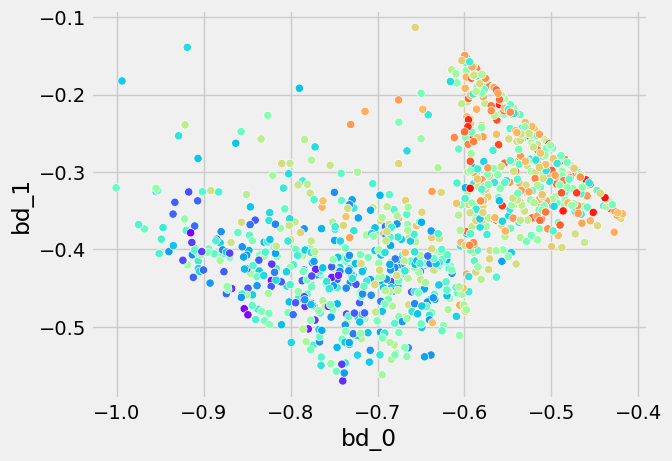

In [84]:
sns.scatterplot(data=df, x='bd_0', y="bd_1", hue="zr",
                legend=False, palette="rainbow")

In [50]:
from evaluators.diversity_evaluator import sparsity

In [68]:
bds = data['eval_data']['bd']
scores = data['eval_data']['score']
gen_bests = jnp.argmax(scores, axis=1)[:, 0]
gen_bests.shape
best_bds = bds[:, gen_bests]

In [65]:
scores.shape

(150, 64, 1)

In [69]:
best_bds.shape

(150, 150, 1, 60, 2)

In [57]:
bds.shape

(150, 64, 1, 60, 2)

In [66]:
bds[best_bds]

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [[[[[-0.7324339  -0.5091685 ]
    [-0.87719274 -0.46396178]
    [-0.60458434 -0.44261298]
    ...
    [-0.5907742  -0.45642725]
    [-0.6434386  -0.4037873 ]
    [-0.5760681  -0.47113124]]]


  [[[-0.625904   -0.4136315 ]
    [-0.66877687 -0.40227   ]
    [-0.71216965 -0.49319166]
    ...
    [-0.6651317  -0.35251066]
    [-0.59581554 -0.40298027]
    [-0.8881991  -0.41844264]]]


  [[[-0.8919981  -0.4519517 ]
    [-0.50030816 -0.3518276 ]
    [-0.8479263  -0.4310039 ]
    ...
    [-0.5082378  -0.3574056 ]
    [-0.89323604 -0.45094714]
    [-0.74437904 -0.43313977]]]


  ...


  [[[-0.755143   -0.4582157 ]
    [-0.5886766  -0.33432016]
    [-0.58588064 -0.43624547]
    ...
    [-0.65398234 -0.39992717]
    [-0.6039828  -0.43332154]
    [-0.57922494 -0.32631996]]]


  [[[-0.83488643 -0.4993579 ]
    [-0.85098314 -0.45545405]
    [-0.92428994 -0.4207499 ]
    ...
    [-0.59101886 -0.44431037]
    [-0.87944096 -0.46213865]
    [-0.96262485 -0.39303154]]]


  [[[-0.6604699  -0.36584017]
    [-0.85863155 -0.37278098]
    [-0.6555118  -0.43455538]
    ...
    [-0.61575925 -0.44260713]
    [-0.61481315 -0.4333822 ]
    [-0.7565273  -0.4062007 ]]]]



 [[[[-0.7072845  -0.44446456]
    [-0.81300503 -0.5183719 ]
    [-0.8366425  -0.43706125]
    ...
    [-0.85939765 -0.4787188 ]
    [-0.93700254 -0.41669714]
    [-0.7630271  -0.34232202]]]


  [[[-0.55863476 -0.3034041 ]
    [-0.5936541  -0.28386697]
    [-0.5471789  -0.4298756 ]
    ...
    [-0.57847595 -0.27475992]
    [-0.5813703  -0.25208145]
    [-0.813595   -0.39571115]]]


  [[[-0.550291   -0.20947096]
    [-0.85391057 -0.4069095 ]
    [-0.8971944  -0.44777006]
    ...
    [-0.94846123 -0.40795788]
    [-0.88395756 -0.45842934]
    [-0.92131007 -0.42873326]]]


  ...


  [[[-0.8063172  -0.21996146]
    [-0.73942363 -0.37376222]
    [-0.60961926 -0.28398868]
    ...
    [-0.7185199  -0.44622615]
    [-0.5603698  -0.37252513]
    [-0.75570863 -0.41848305]]]


  [[[-0.6243862  -0.41907012]
    [-0.65166664 -0.35684854]
    [-0.8408226  -0.30100772]
    ...
    [-0.60628563 -0.42151827]
    [-0.5990953  -0.431642  ]
    [-0.6511945  -0.41148648]]]


  [[[-0.5580285  -0.26760712]
    [-0.85411644 -0.46448252]
    [-0.6061055  -0.41476145]
    ...
    [-0.7376915  -0.43556008]
    [-0.832017   -0.49305925]
    [-0.53015834 -0.3587793 ]]]]



 [[[[-0.79143274 -0.4506773 ]
    [-0.95123976 -0.40583655]
    [-0.7304254  -0.5546357 ]
    ...
    [-0.8122763  -0.45295388]
    [-0.8430326  -0.46269396]
    [-0.9013106  -0.43949565]]]


  [[[-0.6626986  -0.46402064]
    [-0.7534536  -0.29150262]
    [-0.72634876 -0.5649706 ]
    ...
    [-0.8076859  -0.45800257]
    [-0.90670145 -0.43687645]
    [-0.9254469  -0.42551878]]]


  [[[-0.5774131  -0.24392919]
    [-1.2         0.08643257]
    [-1.0244033  -0.12454211]
    ...
    [-1.2        -0.06804743]
    [-0.57681066 -0.36214215]
    [-0.56661725 -0.19151554]]]


  ...


  [[[-0.84247124 -0.4928796 ]
    [-0.53478587 -0.40913597]
    [-0.8292452  -0.44811094]
    ...
    [-0.8134753  -0.41784754]
    [-0.7644926  -0.54159045]
    [-0.7399371  -0.43639737]]]


  [[[-0.8789636  -0.42534065]
    [-0.92618334 -0.424956  ]
    [-0.93383056 -0.4190834 ]
    ...
    [-0.7988401  -0.42663002]
    [-0.74531895 -0.40983796]
    [-0.84005487 -0.49491912]]]


  [[[-0.9470858  -0.3961108 ]
    [-0.7405257  -0.43239114]
    [-0.9505866  -0.38831547]
    ...
    [-0.85244644 -0.417016  ]
    [-0.8234277  -0.50920564]
    [-0.7539214  -0.5712904 ]]]]



 ...



 [[[[-0.7072845  -0.44446456]
    [-0.81300503 -0.5183719 ]
    [-0.8366425  -0.43706125]
    ...
    [-0.85939765 -0.4787188 ]
    [-0.93700254 -0.41669714]
    [-0.7630271  -0.34232202]]]


  [[[-0.55863476 -0.3034041 ]
    [-0.5936541  -0.28386697]
    [-0.5471789  -0.4298756 ]
    ...
    [-0.57847595 -0.27475992]
    [-0.5813703  -0.25208145]
    [-0.813595   -0.39571115]]]


  [[[-0.550291   -0.20947096]
    [-0.85391057 -0.4069095 ]
    [-0.8971944  -0.44777006]
    ...
    [-0.94846123 -0.40795788]
    [-0.88395756 -0.45842934]
    [-0.92131007 -0.42873326]]]


  ...


  [[[-0.8063172  -0.21996146]
    [-0.73942363 -0.37376222]
    [-0.60961926 -0.28398868]
    ...
    [-0.7185199  -0.44622615]
    [-0.5603698  -0.37252513]
    [-0.75570863 -0.41848305]]]


  [[[-0.6243862  -0.41907012]
    [-0.65166664 -0.35684854]
    [-0.8408226  -0.30100772]
    ...
    [-0.60628563 -0.42151827]
    [-0.5990953  -0.431642  ]
    [-0.6511945  -0.41148648]]]


  [[[-0.5580285  -0.26760712]
    [-0.85411644 -0.46448252]
    [-0.6061055  -0.41476145]
    ...
    [-0.7376915  -0.43556008]
    [-0.832017   -0.49305925]
    [-0.53015834 -0.3587793 ]]]]



 [[[[-0.6675362  -0.37968782]
    [-0.6406688  -0.19634551]
    [-0.6190134  -0.35233998]
    ...
    [-0.54073197 -0.4621967 ]
    [-0.52434105 -0.25237158]
    [-0.7205209  -0.0433814 ]]]


  [[[-0.683479   -0.33191395]
    [-0.57086605 -0.43025473]
    [-0.69575334 -0.4742259 ]
    ...
    [-0.55745065 -0.36936975]
    [-0.7957545  -0.28926402]
    [-0.57526076 -0.41428116]]]


  [[[-0.61873597 -0.42849252]
    [-0.8114021  -0.40278098]
    [-0.85121197 -0.44305316]
    ...
    [-0.5519881  -0.45810652]
    [-0.58511716 -0.4620786 ]
    [-0.612473   -0.43473682]]]


  ...


  [[[-0.8350144  -0.44126636]
    [-0.5298185  -0.34449208]
    [-0.5862457  -0.3441402 ]
    ...
    [-0.5309297  -0.3940085 ]
    [-0.5633788  -0.38927773]
    [-0.8155734  -0.3558892 ]]]


  [[[-0.78367025 -0.3507616 ]
    [-0.8025391  -0.43213376]
    [-0.6683197  -0.40400946]
    ...
    [-0.8224623  -0.5100461 ]
    [-0.85553324 -0.4201989 ]
    [-0.75470155 -0.47489068]]]


  [[[-0.6742939  -0.30430958]
    [-0.6099951  -0.40712786]
    [-0.6063549  -0.44081688]
    ...
    [-0.58319944 -0.40474722]
    [-0.60273755 -0.30955333]
    [-0.6075545  -0.38830522]]]]



 [[[[-0.77162665 -0.5056038 ]
    [-0.66179883 -0.4613588 ]
    [-0.9845171  -0.35123125]
    ...
    [-0.5978958  -0.30510008]
    [-0.8877912  -0.28966635]
    [-0.5899758  -0.40973094]]]


  [[[-0.6883679  -0.3530471 ]
    [-0.69893897 -0.33984956]
    [-0.5768755  -0.48030388]
    ...
    [-0.61607003 -0.4264252 ]
    [-0.752156   -0.3641298 ]
    [-0.67436814 -0.37503004]]]


  [[[-0.86775595 -0.4717571 ]
    [-0.7276308  -0.49568868]
    [-0.72461134 -0.45880228]
    ...
    [-0.78080964 -0.50498104]
    [-0.72481304 -0.50562996]
    [-0.6042624  -0.3921749 ]]]


  ...


  [[[-0.74490887 -0.4352596 ]
    [-0.6677438  -0.45741004]
    [-0.8874964  -0.39747342]
    ...
    [-0.74696815 -0.45632836]
    [-0.74829555 -0.42262682]
    [-0.7003021  -0.45826712]]]


  [[[-0.71663564 -0.31963688]
    [-0.5019794  -0.32597268]
    [-0.64978915 -0.41830423]
    ...
    [-0.5501497  -0.35058844]
    [-0.6839317  -0.41233152]
    [-0.627057   -0.45406166]]]


  [[[-0.88640636 -0.44006154]
    [-0.70134324 -0.4097111 ]
    [-0.6356938  -0.41407967]
    ...
    [-0.80581045 -0.49732843]
    [-0.75468653 -0.5084031 ]
    [-0.83185023 -0.36742187]]]]]

In [25]:
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, best_test_data = evaluator.test(test_key, best_params, n_samples=1000, 
#                                   render=False)
# bd_extractor = evaluator.config.bd_extractor
# bds_best = jax.vmap(bd_extractor)(best_test_data)

In [26]:
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, worst_test_data = evaluator.test(test_key, worst_params, n_samples=1000, 
#                                   render=False)
# bd_extractor = evaluator.config.bd_extractor
# bds_worst = jax.vmap(bd_extractor)(worst_test_data)

In [27]:
# s=20.
# plt.scatter(bds_best[:, 0], bds_best[:, 1], label='evolved NDP',
#            alpha = .3, s=s)
# plt.scatter(bds_worst[:, 0], bds_worst[:, 1], label='random NDP',
#            alpha=.3, s=s)
# plt.legend()
# plt.xlabel('min x')
# plt.ylabel('max x')
# plt.show()

# Eval

In [28]:
# from evaluators.simple_evaluator import SimpleEvaluator, SimpleEvaluator_Config

In [29]:
# opt_config = SimpleEvaluator_Config(
#     epochs = 200,
#     env = env,
#     env_params = env_params,
#     env_steps = 200,
#     mlp_hidden_dims = mlp_hidden_dims,
#     mlp_hidden_layers = mlp_hidden_layers,
#     n_params = z_dims,
#     es = "openes",
#     popsize = 128
# )

# opt = SimpleEvaluator(opt_config, ndp)

In [30]:
# key = jax.random.PRNGKey(33)
# best_fit, best_data = opt.eval(best_params, key)
# best_fit

In [31]:
# fitness = best_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

In [32]:
# worst_fit, worst_data = opt.eval(worst_params, key)

In [33]:
# fitness = worst_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

# Visualize

In [34]:
# %%capture
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, best_params, n_samples=5, 
#                                   render=True, save_file="best")

In [35]:
# ipyplot.plot_images(files)

In [36]:
# %%capture
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, worst_params, n_samples=5, 
#                                   render=True, save_file="best")

In [37]:
# ipyplot.plot_images(files)